In [0]:
# import libraries
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from keras import backend as k
import time
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(2017)
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Dense, Activation, Dropout, Add, Flatten
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.datasets import cifar10




Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [0]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
# load data
(X_train, y_train),(X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
# View images

# check the shape of the data set

print(X_train.shape) # 50k images of size 32X32 and 3 channels
print(X_test.shape) # 10 k images

#num_train,img_channels, img_rows, img_cols = train_features.shape[0], train_features.shape[3],train_features.shape[1],train_features.shape[2]

num_train, img_rows, img_cols,img_channels = X_train.shape
print(num_train, img_channels, img_rows, img_cols)

num_test, _, _, _ = X_test.shape
num_classes = len(np.unique(y_train))
print(num_classes)
print(y_train[:])

(50000, 32, 32, 3)
(10000, 32, 32, 3)
50000 3 32 32
10
[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


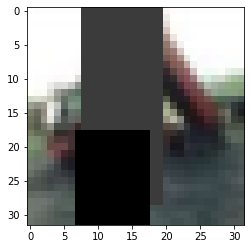

In [0]:
# test out the cutout by extracting one image
#plt.imshow(X_train[10])

img = X_train[2]
plt.imshow(img)

# singe image erasor (cutout)
eraser = get_random_eraser()
img1 = eraser(img)
eraser2 = get_random_eraser(v_l=0, v_h=1, pixel_level=True)
img2 = eraser2(img)

#plt.imshow(img1)
plt.imshow(img2)


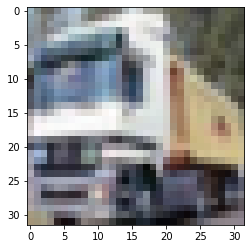

In [0]:

raw_img = X_train[1]
plt.imshow(raw_img)

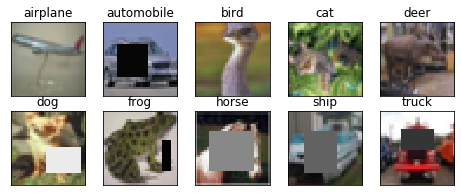

In [0]:
# plot 10 classified images with cutouts
# plot the images random selection

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))

for i in range(num_classes):
  ax = fig.add_subplot(2,5, 1+i, xticks=[], yticks=[])
  idx = np.where(y_train[:]==i)[0] # gets the index values for image number = i
  features_idx = X_train[idx,::] # feature values for idx labes is stored in features_idx.
  img_num = np.random.randint(features_idx.shape[0]) # select a random number from the feature_idx
  im = features_idx[img_num]
  ax.set_title(class_names[i])
  #print(class_names[int(train_labels[img_num])], train_labels[img_num])
  im = eraser(im)
  plt.imshow(im)

plt.show()

In [0]:
# plot model histrory function
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Print Accuracy Function

def accuracy(test_x, test_y, model):
  result = model.predict(test_x)
  predicted_class = np.argmax(result, axis=1)
  true_class = np.argmax(test_y, axis=1)
  num_correct = np.sum(predicted_class == true_class)
  accuracy = float(num_correct)/result.shape[0]
  return accuracy*100

In [0]:

# image normalize and one hot encoding
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
# convert class labels to binary class labels
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [0]:
model = Sequential()

model.add(Convolution2D(64, (3, 3), border_mode='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.1))

model.add(Convolution2D(128, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.1))


model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 1))



model.add(Convolution2D(64, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.1))

model.add(Convolution2D(128, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.1))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 1))

model.add(Convolution2D(64, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.1))

model.add(Convolution2D(128, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.1))


model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 1))

model.add(Convolution2D(64, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.1))

model.add(Convolution2D(128, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.1))


model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 1))

model.add(Convolution2D(64, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.1))

model.add(Convolution2D(128, 3, border_mode='same'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.1))

model.add(Convolution2D(10, 2))

model.add(Flatten())
model.add(Activation('softmax'))
model.summary()

# Compile the model


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, 3, padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, 3, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, 3, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, 3, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, 3, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, 3, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.p

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 128)      

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1,
         validation_data=(X_test,y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 20s 403us/step - loss: 1.4939 - acc: 0.4639 - val_loss: 1.2550 - val_acc: 0.5720
Epoch 2/20
50000/50000 [==============================] - 14s 283us/step - loss: 0.9828 - acc: 0.6517 - val_loss: 0.9463 - val_acc: 0.6693
Epoch 3/20
50000/50000 [==============================] - 14s 282us/step - loss: 0.7785 - acc: 0.7248 - val_loss: 0.9477 - val_acc: 0.6849
Epoch 4/20
50000/50000 [==============================] - 14s 283us/step - loss: 0.6688 - acc: 0.7664 - val_loss: 0.7059 - val_acc: 0.7654
Epoch 5/20
50000/50000 [==============================] - 14s 284us/step - loss: 0.5988 - acc: 0.7913 - val_loss: 0.8096 - val_acc: 0.7237
Epoch 6/20
50000/50000 [==============================] - 14s 281us/step - loss: 0.5339 - acc: 0.8151 - val_loss: 0.6880 - val_acc: 0.7697
Epoch 7/20
50000/500

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=10)`
  del sys.path[0]


Epoch 1/10
390/390 [==============================] - 15s 38ms/step - loss: 0.4393 - acc: 0.8489 - val_loss: 0.5286 - val_acc: 0.8339
Epoch 2/10
390/390 [==============================] - 15s 39ms/step - loss: 0.3967 - acc: 0.8615 - val_loss: 0.5754 - val_acc: 0.8244
Epoch 3/10
390/390 [==============================] - 16s 40ms/step - loss: 0.3743 - acc: 0.8700 - val_loss: 0.5219 - val_acc: 0.8380
Epoch 4/10
390/390 [==============================] - 16s 40ms/step - loss: 0.3680 - acc: 0.8723 - val_loss: 0.5567 - val_acc: 0.8222
Epoch 5/10
390/390 [==============================] - 15s 39ms/step - loss: 0.3463 - acc: 0.8785 - val_loss: 0.5775 - val_acc: 0.8195
Epoch 6/10
390/390 [==============================] - 15s 39ms/step - loss: 0.3426 - acc: 0.8807 - val_loss: 0.5129 - val_acc: 0.8403
Epoch 7/10
390/390 [==============================] - 15s 39ms/step - loss: 0.3240 - acc: 0.8860 - val_loss: 0.5055 - val_acc: 0.8427
Epoch 8/10
390/390 [==============================] - 15s 39ms

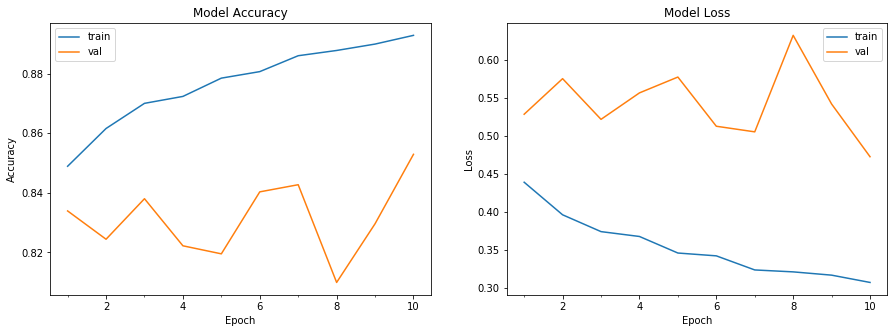

Accuracy on test data is: 85.29


In [0]:
# fit the model using image data generator
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 128),
                                 samples_per_epoch = X_train.shape[0], nb_epoch = 10, 
                                 validation_data = (X_test, y_test), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, y_test, model))

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt

In [0]:
# conv2d_52

last_conv_layer = model.get_layer("conv2d_13")



(32, 32, 3)

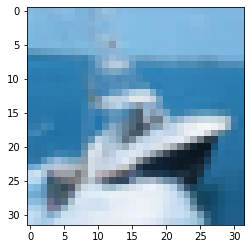

In [0]:
raw_img = X_train[8]
raw_img1 = X_train[8]
plt.imshow(raw_img)
raw_img.shape

In [0]:
# Get an image


img = image.img_to_array(raw_img1)
img = np.expand_dims(img,axis=0)
print(img.max(), img.min(), img.mean())
img = img.astype('float32')/255
#plt.imshow(img)
print(img.max(), img.min(), img.mean())


0.9882353 0.03137255 0.59396833
0.0038754325 0.00012302962 0.0023292874


In [0]:
preds = model.predict(img)
print(preds)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_13")

[[0.14639018 0.02553295 0.10793858 0.07038161 0.332443   0.02920399
  0.07333773 0.0479005  0.10489984 0.06197158]]


In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img])
for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]


In [0]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)



In [0]:
heatmap.shape

(2, 2)

In [0]:
heatmap = cv2.resize(heatmap, (raw_img.shape[1], raw_img.shape[0]))
print(heatmap.shape)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(raw_img, 0.6, heatmap, 0.4,0,dtype = cv2.CV_32F)
#print(heatmap.shape)

#plt.imshow(heatmap)
#plt.show


(32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


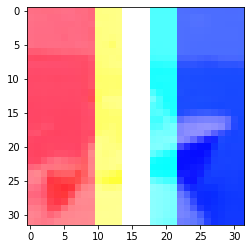

In [0]:
plt.imshow(superimposed_img)

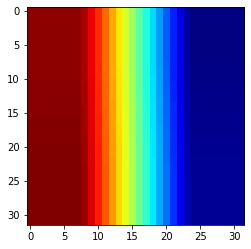

In [0]:
plt.imshow(heatmap)